# Streamflow pre-processing
This Notebook reads streamflow daily observations for a test river basin. From these data, it calculates streamflow volumes for specified target periods.

Decisions:
- We perform a linear interpolation of the daily streamflow data before calculating volumes, to fill in small data gap of maximum 15 days. See user-specified variables below.
- Volumes are calculated for the target periods: January-September, February-September, March-September, ..., September-September. The target periods start dates progressively approach the end of the water year, while the target periods end date is fixed to the end of the water year. See user-specified variables below.

The "Variables" section below is the only section a user will need to modify for testing different options for most of these decisions.

Notes:
- The volumes calculation code assumes that the target periods don't overlap 2 different years.

## Modules, settings & functions

In [1]:
# Import required modules
import datetime
import logging
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import sys
import xarray as xr

In [2]:
# Add scripts to the system path
sys.path.append('../scripts')

# Set up logging, configured for this workflow (see utilities.py)
from utilities import setup_logging, read_settings
setup_logging()

# Set up logging for this notebook
logger = logging.getLogger()

# Suppress misc. comments from being added to the log file
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

%load_ext autoreload
%autoreload 2

2024-10-23 13:10:05,373 - root - INFO - Logging setup complete. Log file: C:\Users\lauri\PycharmProjects\FROSTBYTE\logs\data_driven_forecasting_20241023_131005.log


In [3]:
# Save Notebook name to the log file
logger.debug(f'Notebook: 2_StreamflowPreprocessing')

In [4]:
# Read settings file
settings = read_settings('../settings/config_test_case.yaml', log_settings=True)
pprint(settings)

2024-10-23 13:10:06,018 - root - INFO - Settings logged from ../settings/config_test_case.yaml


{'SWE_obs_path': '../CH_data/CH_input_data/SWE_data.nc',
 'basins_dem_path': '../test_case_data/input_data/MERIT_Hydro_dem_',
 'basins_shp_path': '../CH_data/CH_input_data/nival_basins.shp',
 'domain': '2327',
 'output_data_path': '../CH_data/CH_output_data/',
 'plots_path': '../CH_data/CH_output_plots/',
 'precip_obs_path': '../CH_data/CH_input_data/P_data.nc',
 'streamflow_obs_path': '../CH_data/CH_input_data/Qobs_Camels.nc'}


## Variables

In [5]:
# Set user-specified variables
test_basin_id = settings['domain'] # Can override this with testbasin_id = <string of the testbasin id>, make sure that this id is in the input data files
max_gap_days_default = 15  # max. number of days for gaps in the daily streamflow data we perform linear interpolation for
target_periods = ['01/01-30/09','01/02-30/09','01/03-30/09','01/04-30/09','01/05-30/09','01/06-30/09','01/07-30/09','01/08-30/09','01/09-30/09']  # target periods for volume calculations, where each period is described as 'start_DD/start_MM-end_DD/end_MM'

In [6]:
# Save the user-specified variables to the log file
logger.debug(f'test basin ID: {test_basin_id}')
logger.debug(f'linear interpolation maximum gap (days): {max_gap_days_default}')
logger.debug(f'flow accumulation target periods: {target_periods}')

## Read data

In [7]:
# Read the basin outlet's daily streamflow data as a DataArray 
Qobs_ds = xr.open_dataset(settings['streamflow_obs_path'])
Qobs_testbasin_da = Qobs_ds.where(Qobs_ds.Station_ID==test_basin_id, drop=True).Flow
Qobs_testbasin_da = Qobs_testbasin_da.set_index({"Station_ID":"Station_ID"})

display(Qobs_testbasin_da)

<xarray.DataArray 'Flow' (time: 14610, Station_ID: 1)>
array([[0.473],
       [0.467],
       [0.475],
       ...,
       [0.652],
       [0.635],
       [0.62 ]])
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2020-12-31
    lat         (Station_ID) float64 46.78
    lon         (Station_ID) float64 9.877
    source      (Station_ID) object 'CAMELS'
  * Station_ID  (Station_ID) object '2327'

<IPython.core.display.Javascript object>


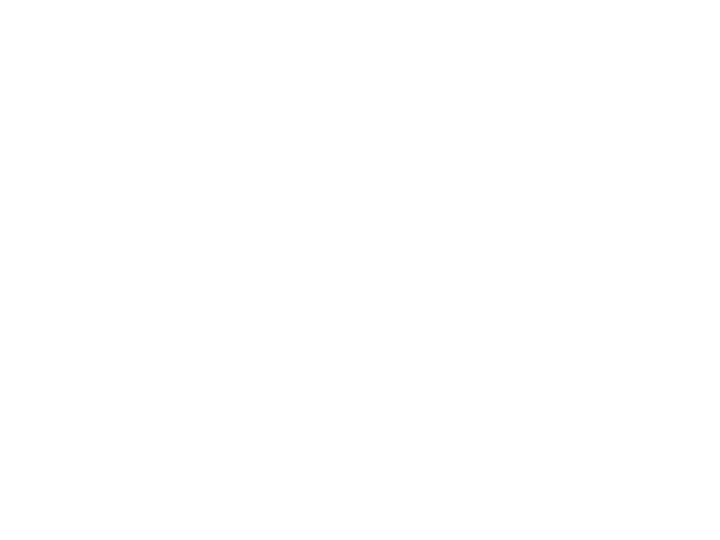

In [8]:
# Plot the basin's daily streamflow data and identify missing data
fig = plt.figure()
Qobs_testbasin_da.plot(lw=.5, color='b')
missing_values = Qobs_testbasin_da.fillna(-1)
missing_values = missing_values.where(missing_values==-1)
missing_values.plot(color='r', label='missing values')
plt.legend()
plt.title('')
plt.tight_layout();

In [9]:
# Save the figure
fig.savefig(settings['plots_path']+"daily_Qobs_basin"+settings['domain']+".png", dpi=300)

In [10]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

## Calculate flow volumes
Here, we calculate flow volumes. In other words, we accumulate daily streamflow values over specified target periods. Note that no volume is saved if there is at least one missing daily streamflow value. To maximize the amount of data, we first run a linear interpolation.

In [11]:
# Perform linear interpolation to fill in small data gaps
interpolated_data = Qobs_testbasin_da.interpolate_na(method='linear', dim='time', max_gap=datetime.timedelta(days=max_gap_days_default))

In [12]:
# Calculate volumes

# loop over target periods
for p in target_periods:

    # define period for which to calculate volumes
    start_day = int(p[0:2])
    start_month = int(p[3:5])
    end_day = int(p[6:8])
    end_month = int(p[9:11])
    start_month_name = datetime.datetime.strptime(str(start_month), "%m").strftime("%b")
    end_month_name = datetime.datetime.strptime(str(end_month), "%m").strftime("%b")

    # calculate volumes for all years' target periods with no missing data
    # for period within the same calendar year
    if start_month <= end_month:
        volumes_period = interpolated_data.sel(time=( ((interpolated_data['time.month'] == start_month) & (interpolated_data['time.day'] >= start_day)) | ((interpolated_data['time.month'] == end_month) & (interpolated_data['time.day'] <= end_day)) | ((interpolated_data['time.month'] > start_month) & (interpolated_data['time.month'] < end_month)) ))
    # for period in 2 calendar years (e.g., 1 December to 31 January)
    elif start_month > end_month:
        volumes_period = interpolated_data.sel(time=( ((interpolated_data['time.month'] == start_month) & (interpolated_data['time.day'] >= start_day)) | ((interpolated_data['time.month'] == end_month) & (interpolated_data['time.day'] <= end_day)) | (interpolated_data['time.month'] > start_month) | (interpolated_data['time.month'] < end_month) ))
    volumes_da = volumes_period.groupby("time.year").sum("time", skipna=False) * 86400

    # save to xarray Dataset
    volumes_da.attrs['long_name'] = 'Volumes'
    volumes_da.attrs['info'] = 'Calculated over time period: '+p
    volumes_da.attrs['units'] = 'm3'
    volumes_da = volumes_da.rename('Vol_'+str(start_day)+start_month_name+'-'+str(end_day)+end_month_name)
    if p == target_periods[0]:
        volumes_testbasin_ds = volumes_da
    else:
        volumes_testbasin_ds = xr.merge([volumes_testbasin_ds,volumes_da])

display(volumes_testbasin_ds)

<xarray.Dataset>
Dimensions:         (Station_ID: 1, year: 40)
Coordinates:
    lat             (Station_ID) float64 46.78
    lon             (Station_ID) float64 9.877
    source          (Station_ID) object 'CAMELS'
  * Station_ID      (Station_ID) object '2327'
  * year            (year) int64 1981 1982 1983 1984 ... 2017 2018 2019 2020
Data variables:
    Vol_1Jan-30Sep  (year, Station_ID) float64 5.154e+07 5.637e+07 ... 4.57e+07
    Vol_1Feb-30Sep  (year, Station_ID) float64 5.044e+07 5.515e+07 ... 4.422e+07
    Vol_1Mar-30Sep  (year, Station_ID) float64 4.961e+07 5.425e+07 ... 4.3e+07
    Vol_1Apr-30Sep  (year, Station_ID) float64 4.839e+07 5.335e+07 ... 4.158e+07
    Vol_1May-30Sep  (year, Station_ID) float64 4.348e+07 5.203e+07 ... 3.743e+07
    Vol_1Jun-30Sep  (year, Station_ID) float64 3.77e+07 4.423e+07 ... 2.875e+07
    Vol_1Jul-30Sep  (year, Station_ID) float64 2.494e+07 2.692e+07 ... 1.878e+07
    Vol_1Aug-30Sep  (year, Station_ID) float64 1.359e+07 1.519e+07 ... 1.181e+07
    Vol_1Sep-30Sep  (year, Station_ID) float64 6.22e+06 6.731e+06 ... 5.805e+06

<IPython.core.display.Javascript object>


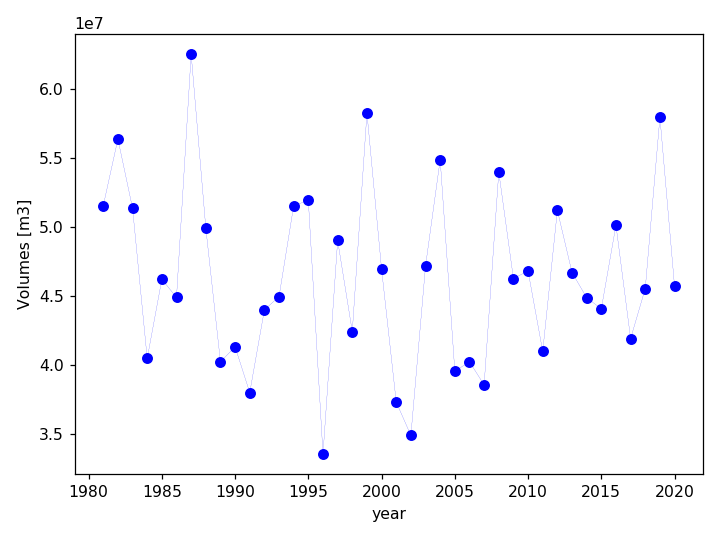

In [13]:
# Plot output volumes for a specific target period to see what they look like
volumes_testbasin_ds['Vol_1Jan-30Sep'].plot(color='b', marker='o', lw=.1)
plt.title('')
plt.tight_layout();

## Save data
Save the output volumes so we can read them in other Notebooks.

In [14]:
# Save the data
volumes_testbasin_ds.to_netcdf(settings['output_data_path']+"Vol_1979_2021_basin"+settings['domain']+".nc", format="NETCDF4")